# Imports and Fixed Variables

In [1]:
import numpy as np
from sklearn.mixture import GaussianMixture
import pickle as pkl
import os
import json
from tqdm import trange
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [2]:
input_folder = "data"
output_folder = "output"

# Function to compute first derivative

In [3]:
def dx_dt(x: np.array, dt: float = 1, method=1):
    """
    This function compute first derivative for the input function x using either central or forward differences

    :param x: input array to compute derivative, should be of shape [num of timestamp, num of attributes]
    :param dt: time stamp size
    :param method: method of computing derivative. 1 is forward difference, 2 is central differences
    :return: dx/dt, would be the same size as x. The first and last element are zero.
    """
    out_dx_dt = np.zeros(x.shape)
    if len(x.shape) == 2:
        for j in range(0, x.shape[1]):
            if method == 1:
                for i in range(0, x.shape[0] - 1):
                    out_dx_dt[i, j] = (x[i + 1, j] - x[i, j])/dt
                out_dx_dt[-1, j] = out_dx_dt[-2, j]
            if method == 2:
                for i in range(1, x.shape[0] - 1):
                    out_dx_dt[i, j] = (x[i + 1, j] - x[i - 1, j]) / 2 / dt
                out_dx_dt[-1, j] = out_dx_dt[-2, j]
                out_dx_dt[0, j] = out_dx_dt[1, j]
    elif len(x.shape) == 1:
        if method == 1:
            for i in range(0, x.shape[0] - 1):
                out_dx_dt[i] = (x[i + 1] - x[i]) / dt
            out_dx_dt[-1] = 0
        if method == 2:
            for i in range(1, x.shape[0] - 1):
                out_dx_dt[i] = (x[i + 1] - x[i - 1]) / 2 / dt
            out_dx_dt[-1] = 0
            out_dx_dt[0] = 0
    return out_dx_dt

# Functions to compute gaze centers and intersections

In [4]:
def dispersion_filtering(x, y, dispersion_threshold = 6, duraiton_threshold=0.3):
    start = 0
    window = []
    fps = int(np.round(1/(x[1] - x[0])))
    duration_threshold_frames = np.ceil(duraiton_threshold * fps)
    
    def dispersion(arr):
        # input is a 2d array
        disp = np.max(arr[:, 0]) - np.min(arr[:, 0]) + np.max(arr[:, 1]) - np.min(arr[:, 1])
        return disp

    fixations = []
    fixations_intervals = []
    
    # while there are still points
    while int(start+duration_threshold_frames) < y.shape[0]:
        # initialize a window:
        window = list(range(int(start), int(start+duration_threshold_frames)))
        start = start + duration_threshold_frames
        disp = dispersion(y[window])
        while disp <= dispersion_threshold:
            disp = dispersion(y[window])
            if window[-1]+1 < y.shape[0]:
                window.append(window[-1]+1)
            start = start + 1
            if start >= y.shape[0]:
                break
        # if the current set of points never fit the duration criteria
        if len(window) <= duration_threshold_frames:
            start = start + 1
        # otherwise note it as fixations
        else:
            centroid = np.mean(y[window], axis=0)
            duration = (window[-1] - window[0]) / fps
            fixations.append([centroid[0], centroid[1], duration])
            fixations_intervals.append([window[0], window[-1]])
    fixations = np.array(fixations)
    return fixations, fixations_intervals

def switch_rate_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    total_in = np.sum(in_cluster)
    # switch rate (we want to maximize the number of gaze shifts between in cluster and out of cluster)
    # the rationale behind this is that gaze shifting outside the cluster 
    swtich = np.sum(np.abs(dx_dt(in_cluster)))/total_in
    rtv = -swtich
    return rtv, total_in

def intra_cluster_distance(points, center, radius):
    dist = np.linalg.norm(points - center, axis=1)
    in_cluster = np.where(dist < radius, 1, 0)
    # intracluster distance
    rtv = np.sum(dist * in_cluster)
    total_in = np.sum(in_cluster)
    rtv = rtv / total_in
    return rtv, total_in

def radius_line_search(points, center, min_member, max_iter=7):
    center = np.expand_dims(center, axis=0)
    radius_max = 20
    radius_min = 1
    for i in range(0, max_iter):
        clustering_goodness_max_r, total_in= switch_rate_distance(points, center, radius_max)
        clustering_goodness_min_r, total_in= switch_rate_distance(points, center, radius_min)
        if clustering_goodness_max_r <= clustering_goodness_min_r and total_in >= min_member:
            radius_max = (radius_max + radius_min)/2
        else:
            radius_min = (radius_max + radius_min)/2
        
    return radius_min   

def find_gaze_target(fixations, gaze_points, vertical_sensitivity=1):

    fixations[:, 1] = fixations[:, 1] * vertical_sensitivity
    gaze_points[:, 1] = gaze_points[:, 1] * vertical_sensitivity
    if fixations.shape[0] <= 2:
        return np.ones((fixations.shape[0], ))

    mixture = GaussianMixture(int(np.minimum(8, fixations.shape[0]))).fit(fixations[:, :2], )
    mix = mixture.predict_proba(fixations[:, :2])
    # get cluster heads
    mixture_centers = mixture.means_
    # find the index of the most likely target
    most_likely_target = np.argmax(np.sum(mix, axis=0))
    most_likely_cluster_member_count = np.where(np.argmax(mix, axis=1) == most_likely_target, 1, 0).sum()
    # find the most likely look at point
    gaze_target = mixture_centers[most_likely_target]
    distance_to_target = np.linalg.norm(gaze_points[:, :2] - np.expand_dims(gaze_target, axis=0), axis=1)
    # use line search to find an appropriete radious of what to include
    radius = radius_line_search(fixations[:, :2], gaze_target, most_likely_cluster_member_count, 7)
    return gaze_target, radius

# Function to increment image values in a gaussian style

In [5]:
def increment_pixel_gaussian(image, center, sigma):
    # Create a 2D Gaussian kernel
    kernel_size = int(2 * np.ceil(2 * sigma) + 1)
    kernel = np.zeros((kernel_size, kernel_size))
    center_index = int(kernel_size / 2)
    for i in range(kernel_size):
        for j in range(kernel_size):
            x = i - center_index
            y = j - center_index
            kernel[i, j] = np.exp(-(x ** 2 + y ** 2) / (2 * sigma ** 2))
    kernel /= np.sum(kernel)
    
    # Increment the pixel values according to the Gaussian kernel
    row, col = int(center[0]), int(center[1])
    row_min = int(max(row - center_index, 0))
    row_max = int(min(row + center_index + 1, image.shape[0]))
    col_min = int(max(col - center_index, 0))
    col_max = int(min(col + center_index + 1, image.shape[1]))
    window = image[row_min:row_max, col_min:col_max]
    weights = kernel[center_index - (row - row_min):center_index + (row_max - row), 
                     center_index - (col - col_min):center_index + (col_max - col)]
    window += weights
    image[row_min:row_max, col_min:col_max] = window
    return image

# Get static saliency map for each shot

In [6]:
video_names_path = os.path.join(*[output_folder, "metadata.json"])
with open(video_names_path, "r") as f:
    video_metadata = json.load(f)["data"]

In [7]:
overall_min_x, overall_max_x = 10000, -10000
overall_min_y, overall_max_y = 10000, -10000
for shot_id in trange(0, len(os.listdir(os.path.join('output', 'gaze')))):
    gaze = np.load(os.path.join(*[output_folder, "gaze", f'clip_{shot_id}.npy']))
    ts = np.arange(0, gaze.shape[0]) / 25
    fixations, fixations_intervals = dispersion_filtering(ts, gaze, dispersion_threshold=6, duraiton_threshold=0.2)
    # print(list(find_gaze_target(fixations, gaze)))

    fixation_t = np.zeros(gaze.shape)
    for i in range(0, len(fixations_intervals)):
        for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
            fixation_t[k] = fixations[i, :2]
        if i == 0:
            for k in range(0, fixations_intervals[i][1]):
                fixation_t[k] = fixations[i, :2]
        else:
            for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
                fixation_t[k] = fixations[i, :2]
        if i == (len(fixations_intervals) - 1):
            for k in range(fixations_intervals[i][1], len(fixations_intervals)):
                fixation_t[k] = fixations[i, :2]

    min_x, max_x = np.min(fixation_t[:, 0]), np.max(fixation_t[:, 0])
    min_y, max_y = np.min(fixation_t[:, 1]), np.max(fixation_t[:, 1])
    overall_min_x = min(overall_min_x, min_x)
    overall_max_x = max(overall_max_x, max_x)
    overall_min_y = min(overall_min_y, min_y)
    overall_max_y = max(overall_max_y, max_y)

100%|██████████| 3900/3900 [00:06<00:00, 645.40it/s]


In [8]:
overall_max_x, overall_min_x, overall_max_y, overall_min_y = np.ceil(overall_max_x), np.ceil(overall_min_x), np.ceil(overall_max_y), np.ceil(overall_min_y)

In [9]:
# TODO: Convert all negative values to positive. Work with angles 0-360
overall_max_x, overall_min_x, overall_max_y, overall_min_y

(119.0, -169.0, 156.0, -316.0)

In [10]:
canvas_size = (overall_max_x - overall_min_x, overall_max_y - overall_min_y)
canvas_size = (int(np.ceil(canvas_size[0])), int(np.ceil(canvas_size[1])))
for shot_id in trange(0, len(os.listdir(os.path.join('output', 'gaze')))):
    gaze = np.load(os.path.join(*[output_folder, "gaze", f'clip_{shot_id}.npy']))
    ts = np.arange(0, gaze.shape[0]) / 25
    fixations, fixations_intervals = dispersion_filtering(ts, gaze, dispersion_threshold=6, duraiton_threshold=0.2)
    image = np.zeros((int(np.ceil(canvas_size[0])), int(np.ceil(canvas_size[1]))))
    if len(fixations.shape) < 2:
        np.save(os.path.join(output_folder, "saliency_map", f"clip_{shot_id}.npy"), image)
        np.save(os.path.join(output_folder, "fixation", f"clip_{shot_id}.npy"), fixations)
        continue

    fixation_t = np.zeros(gaze.shape)
    for i in range(0, len(fixations_intervals)):
        for k in range(fixations_intervals[i][0], fixations_intervals[i][1]+1):
            fixation_t[k] = fixations[i, :2]
        if i == 0:
            for k in range(0, fixations_intervals[i][1]):
                fixation_t[k] = fixations[i, :2]
        else:
            for k in range(fixations_intervals[i-1][1], fixations_intervals[0][0]):
                fixation_t[k] = fixations[i, :2]
        if i == (len(fixations_intervals) - 1):
            for k in range(fixations_intervals[i][1], len(fixations_intervals)):
                fixation_t[k] = fixations[i, :2]
    
    fixation_t[:, 0] += abs(overall_min_x)
    fixation_t[:, 1] += abs(overall_min_y)

    for point in fixation_t:
        point_x = int(point[0])
        point_y = int(point[1])
        image = increment_pixel_gaussian(image, point, 10)
        # image[point_x, point_y] += 1 / np.prod(image.shape)
        # if point_x > 0:
        #     image[point_x-1, point_y] += 1 / (np.prod(image.shape) * 9)
        #     if point_y > 0:
        #         image[point_x-1, point_y-1] += 1 / (np.prod(image.shape) * 9)
        # if point_x < image.shape[0]-1:
        #     image[point_x+1, point_y] += 1 / (np.prod(image.shape) * 9)
        #     if point_y < image.shape[1]-1:
        #         image[point_x+1, point_y+1] += 1 / (np.prod(image.shape) * 9)
        # if point_y > 0:
        #     image[point_x, point_y-1] += 1 / (np.prod(image.shape) * 9)
        #     if point_x < image.shape[0]-1:
        #         image[point_x+1, point_y-1] += 1 / (np.prod(image.shape) * 9)
        # if point_y < image.shape[1]-1:
        #     image[point_x, point_y+1] += 1 / (np.prod(image.shape) * 9)
        #     if point_x > 0:
        #         image[point_x-1, point_y+1] += 1 / (np.prod(image.shape) * 9)
    # save image and fixation as .npy
    np.save(os.path.join(output_folder, "saliency_map", f"clip_{shot_id}.npy"), image)
    np.save(os.path.join(output_folder, "fixation", f"clip_{shot_id}.npy"), fixation_t)

 20%|█▉        | 776/3900 [05:23<21:41,  2.40it/s]


KeyboardInterrupt: 

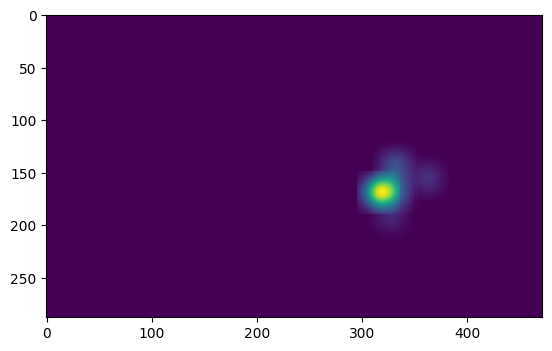

In [ ]:
plt.imshow(np.load(os.path.join(output_folder, "saliency_map", "clip_0.npy")))

# Dataloader

In [ ]:
class SaliencyMapAudio(Dataset):
    def __init__(self, processed_data_path):
        self.filler = np.array([-36.04365338911715,0.0,0.0,0.0,0.0,0.0,-3.432169450445466e-14,0.0,0.0,0.0,9.64028691651994e-15,0.0,0.0,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715,-36.04365338911715])
        # save dataset root path
        self.data_root_path = processed_data_path
        # load video names
        video_names_path = os.path.join(*[self.data_root_path, "video_to_window_metadata.json"])
        self.metadata = json.load(open(video_names_path, "r"))
        self.all_files_in_set = []
        videos_included = list(self.metadata.keys())
        for i in videos_included:
            self.all_files_in_set = self.all_files_in_set + self.metadata[i]

    def __len__(self):
        return len(self.all_files_in_set)
    
    def __getitem__(self, idx):
        onscreen_audio_feature_path = os.path.join(*[self.data_root_path, "audio", "clip_{}_speaker_{}.npy".format(idx, 0)])
        offscreen_audio_feature_path = os.path.join(*[self.data_root_path, "audio", "clip_{}_speaker_{}.npy".format(idx, 1)])
        onscreen_text_feature_path = os.path.join(*[self.data_root_path, "text", "clip_{}_speaker_{}.npy".format(idx, 0)])
        offscreen_text_feature_path = os.path.join(*[self.data_root_path, "text", "clip_{}_speaker_{}.npy".format(idx, 1)])
        
        input_audio_on_screen = np.load(onscreen_audio_feature_path)
        input_audio_off_screen = np.load(offscreen_audio_feature_path)
        
        input_text_on_screen = np.load(onscreen_text_feature_path)
        input_text_off_screen = np.load(offscreen_text_feature_path)
            
        if input_audio_on_screen.shape[0] < input_text_on_screen.shape[0]:
            missing_frames = input_text_on_screen.shape[0] - input_audio_on_screen.shape[0]
            padding = np.tile(np.expand_dims(self.filler, axis=0), [missing_frames, 1])
            input_audio_on_screen = np.concatenate([input_audio_on_screen, padding], axis=0)
            input_audio_off_screen = np.concatenate([input_audio_off_screen, padding], axis=0)
        input_vector_onscreen = np.concatenate([input_audio_on_screen, input_text_on_screen], axis=1)
        input_vector_offscreen = np.concatenate([input_audio_off_screen, input_text_off_screen], axis=1)
        input_vector = np.concatenate([input_vector_onscreen, input_vector_offscreen], axis=1)

        saliency_map = np.load(os.path.join(self.data_root_path, "saliency_map", f"clip_{idx}.npy"))

        fixations = np.load(os.path.join(self.data_root_path, "fixation", f"clip_{idx}.npy"))
        if len(fixations.shape) == 2:
            targets = []
            for i in range(fixations.shape[0]):
                cur_target = np.zeros(saliency_map.shape)
                fixation_center = fixations[i]
                image_to_add = increment_pixel_gaussian(cur_target, fixation_center, 10)
                assert cur_target.shape == image_to_add.shape
                targets.append(image_to_add)
        else:
            targets = [np.zeros(saliency_map.shape) for _ in range(input_vector.shape[0])]

        return input_vector, saliency_map, np.array(targets)

In [ ]:
# Each element in the dataset is a tuple of (input_vector, saliency_map, target)
#   The input_vector is a concatenation of the onscreen and offscreen audio and text features
#   It consists of 250 frames

#   The saliency_map is an image with values between 0 and 1. It is the saliency map for the clip

#   The target is a list of images with values between 0 and 1. It is the fixation map for each frame in the clip
dataset = SaliencyMapAudio('output')

In [ ]:
original_x1_shape = dataset.__getitem__(0)[0].shape
original_x2_shape = dataset.__getitem__(0)[1].shape
original_y_shape = dataset.__getitem__(0)[2].shape
for i in trange(dataset.__len__()):
    x1, x2, y = dataset.__getitem__(i)
    if x1.shape != original_x1_shape:
        print('x1', x1.shape, original_x1_shape)
    if x2.shape != original_x2_shape:
        print('x2', x2.shape, original_x2_shape)
    if y.shape != original_y_shape:
        print('y', y.shape, original_y_shape)

100%|██████████| 3900/3900 [05:07<00:00, 12.70it/s]
